# Vertical Collision Avoidance (VCAS)


This example [1, 2] considers commercial aircraft, which are required to operate
with a collision avoidance system that gives vertical climbrate advisories to
pilots to prevent near midair collisions (NMACs). An NMAC occurs when the
aircraft are separated by less than 100 ft vertically and 500 ft horizontally.

In [1]:
using NeuralNetworkAnalysis

## Model

This benchmark is a closed-loop variant of aircraft collision avoidance
system ACAS X. The scenario involves two aircraft, the ownship and the
intruder, where the ownship is equipped with a collision avoidance system
referred to as VerticalCAS [3]. VerticalCAS once every second issues vertical
climbrate advisories to the ownship pilot to avoid a near mid-air collision
(NMAC), a region where the ownship and intruder are separated by less than
100ft vertically and 500ft horizontally. The ownship (black) is assumed
to have a constant horizontal speed, and the intruder (red) is assumed to
follow a constant horizontal trajectory towards ownship, see Figure 1.
The current geometry of the system is described by

1) $h(ft)$: Intruder altitude relative to ownship
2) $\dot h_0 (ft/min)$: Ownship vertical climbrate
3) $τ(s)$: the seconds until the ownship (black) and intruder (red) are no longer horizontally separated

We can, therefore, assume that the intruder is static and the horizontal
separation $\tau$ decreases by one each second.
There are 9 advisories and each of them instructs the pilot to accelerate
until the vertical climbrate of the ownship complies with the advisory:

1) COC: Clear of Conflict
2) DNC: Do Not Climb
3) DND: Do Not Descend
4) DES1500: Descend at least 1500 ft/min
5) CL1500: Climb at least 1500 ft/min
6) SDES1500: Strengthen Descent to at least 1500 ft/min
7) SCL1500: Strengthen Climb to at least 1500 ft/min
8) SDES2500: Strengthen Descent to at least 2500 ft/min
9) SCL2500: Strengthen Climb to at least 2500 ft/min

In addition to the parameters describing the geometry of the encounter, the
current state of the system stores the advisory $adv$ issued to the ownship
at the previous time step. VerticalCAS is implemented as nine ReLU networks
$N_i$, one for each (previous) advisory, with three inputs
$(h,\dot{h}_0,\tau)$, five fully-connected hidden layers of 20 units each,
and nine outputs representing the score of each possible advisory. Therefore,
given a current state $(h,\dot{h}_0,\tau,\text{adv})$, the new advisory
$adv$ is obtained by computing the argmax of the output of $N_{\text{adv}}$
on $(h,\dot{h}_0,\tau)$.
Given the new advisory, if the current climbrate does not comply with it, the
pilot can choose acceleration $\ddot{h}_0$ from the given set:

1) COC: $\{-\frac{g}{8}, 0, \frac{g}{8}\}$
2) DNC: $\{-\frac{g}{3}, -\frac{7g}{24}, -\frac{g}{4}\}$
3) DND: $\{\frac{g}{4}, \frac{7g}{24}, \frac{g}{3}\}$
4) DES1500: $\{-\frac{g}{3}, -\frac{7g}{24}, -\frac{g}{4}\}$
5) CL1500: $\{\frac{g}{4}, \frac{7g}{24}, \frac{g}{3}\}$
6) SDES1500: $\{-\frac{g}{3}\}$
7) SCL1500: $\{\frac{g}{3}\}$
8) SDES2500: $\{-\frac{g}{3}\}$
9) SCL2500: $\{\frac{g}{3}\}$

where $g$ represents the gravitational constant $32.2 \ \text{ft/s}^2$.
If the new advisory is COC(1), then it can be any acceleration from the set ${−g/8, 0, g/8}$.
For all remaining advisories, if the previous advisory coincides with the new one and the
current climb rate complies with the new advisory (e.g., $\dot{h}_0$ is non-positive for DNC and
$\dot{h}_0 ≥ 1500$ for CL1500) the acceleration `\ddot{h}_0$ is $0$.

Given the current system state $(h,\dot{h}_0,\tau,\text{adv})$, the new
advisory $\text{adv}'$ and the acceleration $\ddot{h}_0$, the new state
of the system $(h(t+1),\dot{h}_0(t+1),\tau(t+1),\text{adv}(t+1))$ can
be computed as follows:

$$
\begin{aligned}
h(t+1) &=& h - \dot{h}_0 \Delta\tau - 0.5 \ddot{h}_0 \Delta\tau^2 \\
\dot{h}_0(t+1) &=& \dot{h}_0 + \ddot{h}_0 \Delta\tau \\
\tau(t+1) &=& \tau - \Delta\tau \\
\text{adv}(t+1) &=& \text{adv}'
\end{aligned}
$$
where $\Delta\tau=1$.

In [2]:
const g = 32.2  # gravitational constant

# accelerations (middle)
const ACC_MIDDLE = Dict(:COC => 0.0, :DNC => -7g/24, :DND => 7g/24,
                        :DES1500 => -7g/24, :CL1500 => 7g/24, :SDES1500 => -g/3,
                        :SCL1500 => g/3, :SDES2500 => -g/3, :SCL2500 => g/3)

# continuous dynamics matrix (h, hdot0)
const Δτ = 1.0
const A = [1  -Δτ; 0  1.];

We load the controllers in a dictionary with the keys being the advisories.

In [3]:
CONTROLLERS = Dict{Symbol, Any}()

CTRL_IDX = [:COC, :DNC, :DND, :DES1500,
            :CL1500, :SDES1500, :SCL1500,
            :SDES2500, :SCL2500]

path = @modelpath("VertCAS", "")
for i = 1:9
    file = joinpath(path, "VertCAS_noResp_pra0$(i)_v9_20HU_200.nnet")
    adv = CTRL_IDX[i]
    CONTROLLERS[adv] = read_nnet(file)
end


struct State{T, N}
    state::T # state for (h, hdot0) variables
    τ::N
    adv::Symbol
end


ADVISORIES = Dict{Symbol, Any}()

# for every advisory, return a function to check
# whether the current climbrate complies with the advisory or not
# if the advisory *does not* comply => it is changed according to the ACC dictionary
# otherwise, the new acceleration is zero
using Symbolics
@variables x

ADVISORIES[:COC] = EmptySet(1)
ADVISORIES[:DNC] = HalfSpace(x <= 0)
ADVISORIES[:DND] = HalfSpace(x >= 0)
ADVISORIES[:DES1500] = HalfSpace(x <= -1500)
ADVISORIES[:CL1500] = HalfSpace(x >= 1500)
ADVISORIES[:SDES1500] = HalfSpace(x <= -1500)
ADVISORIES[:SCL1500] = HalfSpace(x >= 1500)
ADVISORIES[:SDES2500] = HalfSpace(x <= -2500)
ADVISORIES[:SCL2500] = HalfSpace(x >= 2500)

# this function receives X = [h, hdot0, τ, adv′] and the
# *previous* advisory adv
function get_acceleration(X::State, adv; ACC=ACC_MIDDLE)

    # obtain projection on hdot
    hdot = _interval(X.state, 2)

    # transform units from ft/s to ft/min
    hdot = 60 * hdot

    # new advisory
    adv′ = X.adv

    # check whether the current state complies with the advisory
    comply = hdot ⊆ ADVISORIES[adv′]

    if adv == adv′ && comply
        return 0.0
    else
        return ACC[adv′]
    end
end

# scalar case; alg is ignored
function forward_adv(X::Singleton, τ, adv; alg=nothing)
    v = vcat(element(X), τ)
    u = forward(CONTROLLERS[adv], v)
    imax = argmax(u)
    return CTRL_IDX[imax]
end

# set-based case
function forward_adv(X::AbstractZonotope, τ, adv; alg=Ai2())
    Y = cartesian_product(X, Singleton([τ]))

    out = forward_network(alg, CONTROLLERS[adv], Y)

    imax = argmax(high(out))
    return CTRL_IDX[imax]
end

function VCAS!(out::Vector{State{T, N}}, KMAX; ACC=ACC_MIDDLE, alg_nn=Ai2()) where {T, N}

    # unpack initial state
    X0 = first(out)
    S = X0.state
    τ = X0.τ
    adv = X0.adv

    # get initial acceleration
    hddot = ACC[adv]

    for i in 1:KMAX
        # compute next state
        b = [-hddot*Δτ^2 / 2, hddot * Δτ]
        S′ = affine_map(A, S, b)
        τ′ = τ - 1
        adv′ = forward_adv(S′, τ′, adv, alg=alg_nn)

        # store new state
        X′ = State(S′, τ′, adv′)
        push!(out, X′)

        # get acceleration from network
        # this logic only works for ACC_MIDDLE
        hddot = get_acceleration(X′, adv; ACC=ACC)

        # update current state
        S = S′
        τ = τ′
        adv = adv′
    end
    return out
end;

## Specifications

For this benchmark the aim is to verify that the ownship avoids entering the
NMAC zone after $k \in \{1, \dots, 10\}$ time steps, i.e., $h(k) > 100$ or
$h(k) < -100$, for all possible choices of acceleration by the pilot. The
set of initial states considered is as follows: $h(0) \in [-133, -129]$,
$\dot{h}_0(0) \in \{-19.5, -22.5, -25.5, -28.5\}$, $\tau(0) = 25$ and
$\text{adv}(0) = \text{COC}$.

In [4]:
bad_states = HalfSpace([1.0, 0.0], 100.) ∩ HalfSpace([-1.0, 0.0], 100.)

# property for guaranteed violation
predicate = X -> X ⊆ bad_states
predicate_sol = sol -> any(predicate(R) for F in sol for R in F);

## Results

### Simulation

In [5]:
const h0 = Interval(-133, -129)
const hdot0 = [-19.5,-22.5, -25.5, -28.5]
const τ0 = 25.0
const adv0 = :COC

function _random_states(k=1, include_vertices::Bool=false, rand_h0::Bool=true)
    N = Float64
    T = Singleton{N, Vector{N}}
    states = Vector{State{T, N}}()
    xs = sample(h0, k, include_vertices=include_vertices)
    for x in xs
        if rand_h0
            # use a random value for y
            y = hdot0[rand(1:4)]
            S0 = State(Singleton([x[1], y]), τ0, adv0)
            push!(states, S0)
            continue
        end
        # use all possible values for y
        for i in 1:4
            y = hdot0[i]
            S0 = State(Singleton([x[1], y]), τ0, adv0)
            push!(states, S0)
        end
    end
    return states
end

function _all_states()
    S0 = [convert(Zonotope, concretize(h0 × Singleton([hdot0[i]]))) for i in 1:4]
    return [State(S0i, τ0, adv0) for S0i in S0]
end

function simulate_VCAS(X0::State; KMAX=10)
    out = [X0]
    sizehint!(out, KMAX+1)

    VCAS!(out, KMAX, ACC=ACC_MIDDLE)
    return out
end

# project onto the h variable
function _project(X::Vector{State{T, N}}) where {T<:Singleton, N}
    return [Singleton([Xi.state.element[1], Xi.τ]) for Xi in X]
end

_interval(X::LazySet, i) = overapproximate(Projection(X, (i,)), Interval)

function _project(X::Vector{State{T, N}}) where {T<:Zonotope, N}
    Xint = [_interval(Xi.state, 1) × Singleton([Xi.τ]) for Xi in X]
end

function run(X0)
    ensemble = [simulate_VCAS(X0i) for X0i in X0]
    res = _project.(ensemble)
    return res
end

function check(sol)
    println("property checking")
    res_pred = @timed predicate_sol(sol)
    print_timed(res_pred)
    if res_pred.value
        println("The property is violated.")
    else
        println("The property may be satisfied.")
    end
end;

Simulation result for random choice of velocity:

In [6]:
X0 = _random_states(10, true, false)  # randomly sampled points (incl. vertices)
println("$(length(X0)) simulations with central advisories")
res = @timed begin
    res1 = run(X0)
    check(res1)
end
println("total analysis time")
print_timed(res);

48 simulations with central advisories
property checking
  0.132022 seconds (163.85 k allocations: 10.002 MiB)
The property is violated.
total analysis time
  0.809641 seconds (1.34 M allocations: 80.226 MiB)


Simulation result for all choices of velocity:

In [7]:
println("flowpipe construction (unsound) with central advisories")
res = @timed begin
    res2 = run(_all_states())
    check(res1)
end
println("total analysis time")
print_timed(res);

flowpipe construction (unsound) with central advisories
property checking
  0.000024 seconds (16 allocations: 448 bytes)
The property is violated.
total analysis time
  0.199426 seconds (257.44 k allocations: 16.792 MiB)


Finally we plot the results:

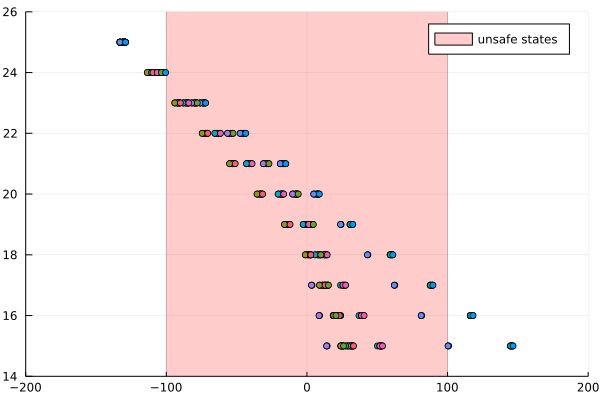

In [8]:
using Plots
import DisplayAs

function plot_helper()
    fig = plot(xlims=(-200, 200), ylims=(14, 26), xlab="h (vertical distance)",
               ylab="τ (time to reach horizontally)")
    plot!(fig, bad_states, alpha=0.2, c=:red, lab="unsafe states")
    return fig
end

fig = plot_helper()
for o in res1
    plot!(fig, o, alpha=1.0)
end
fig = DisplayAs.Text(DisplayAs.PNG(fig))
# savefig("VertCAS-rand.png")
fig

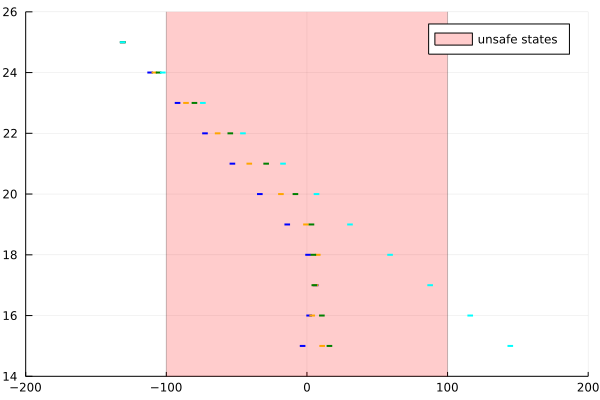

In [9]:
fig = plot_helper()
for (i, c) in [(1, :blue), (2, :orange), (3, :green), (4, :cyan)]
    [plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=c) for o in res2[i]]
end
fig = DisplayAs.Text(DisplayAs.PNG(fig))
# savefig("VertCAS-sets.png")
fig

## References

[1] [Julian, K. D., & Kochenderfer, M. J. (2019). A reachability method for
verifying dynamical systems with deep neural network controllers.
arXiv preprint arXiv:1903.00520.](https://arxiv.org/pdf/1903.00520.pdf)

[2] Akintunde, M. E., Botoeva, E., Kouvaros, P., & Lomuscio, A. (2020, May).
[Formal Verification of Neural Agents in Non-deterministic Environments.
In Proceedings of the 19th International Conference on Autonomous Agents and
Multiagent Systems (pp. 25-33).](http://ifaamas.org/Proceedings/aamas2020/pdfs/p25.pdf)